In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import glob
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /scratch/s2135337/miniconda/base/envs/plot-ce-maps/share/proj failed


In [6]:
station_locDF = pd.DataFrame()

latlon = [[i.split('/')[-1][:6],i.split('/')[-1][7:-4]] for i in glob.glob('/data/causal-effects-v27-01-14/*.npy')]

station_locDF = pd.DataFrame()
station_locDF['id'] = np.arange(len(latlon))

station_locDF['lat'] = np.nan
station_locDF['lon'] = np.nan

station_locDF.columns = station_locDF.columns.str.replace(' ', '')

for i in range(len(latlon)):
    k = np.where(station_locDF.id == i)[0][0]
    station_locDF.loc[k,'lat'] = latlon[i][0]
    station_locDF.loc[k,'lon'] = latlon[i][1]
        
    result = np.load('/data/causal-effects-v27-01-14/'+str(latlon[i][0])+'-'+str(latlon[i][1])+'.npy', allow_pickle = True)
    
    cols = ['AOD-CC','AOD-SW','AOD-Tmin','CC-SW','CC-Tmax','CC-Tmin','SW-Tmax','Tmax-Tmin','Tmin-Tmax','AOD-CC-SW','AOD-Tmin-tot','AOD-Tmax-tot','AOD-SW-tot']
    lab = ['','[W/m2]','[K]','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']
    
    for n in range(13):     
        
        if (0 not in result[n][1:]) and all(~np.isnan(result[n][1:])) and np.unique(np.sign(result[n][1:])).shape[0] == 1:
            if n == 0:
                station_locDF.loc[k, cols[n]] = result[n][0]/100
            elif n in [3,4,5]:
                station_locDF.loc[k, cols[n]] = result[n][0]*100
            else:
                station_locDF.loc[k, cols[n]] = result[n][0]

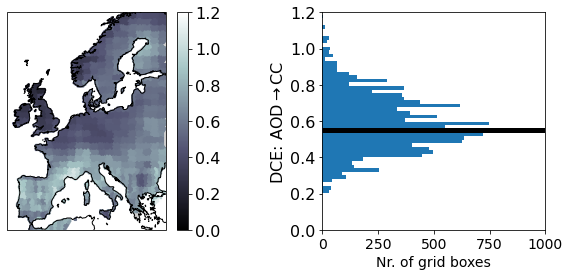

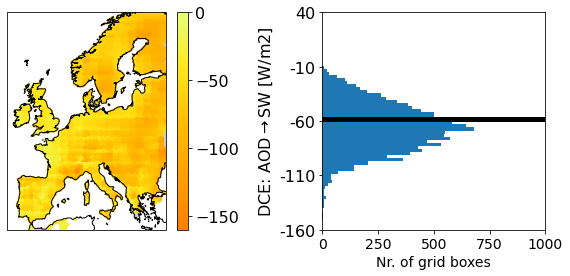

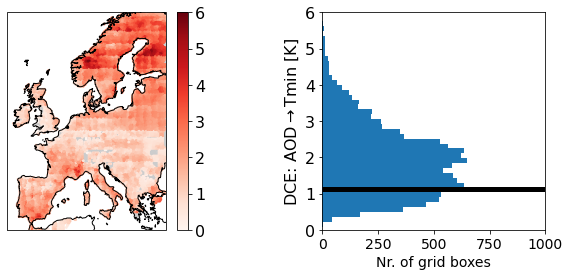

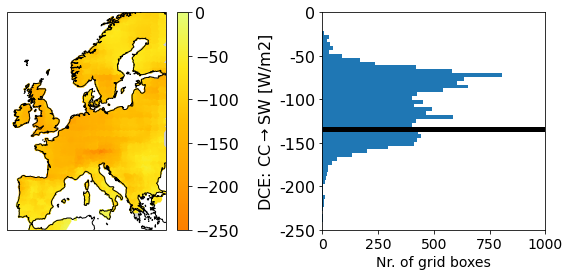

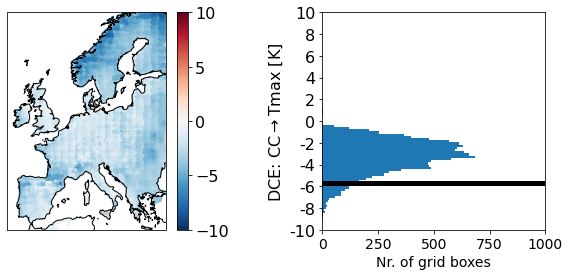

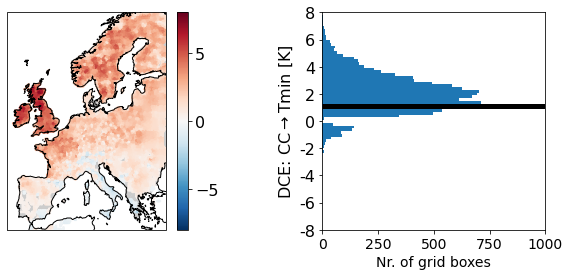

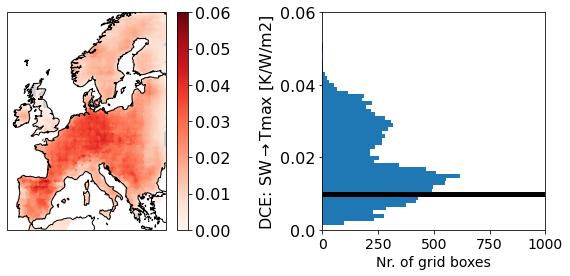

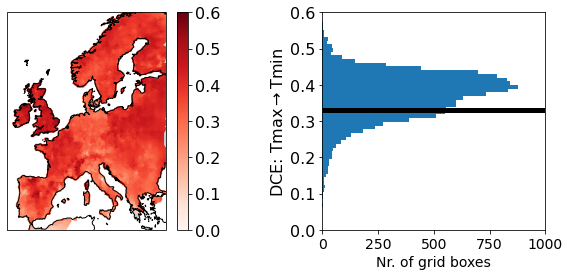

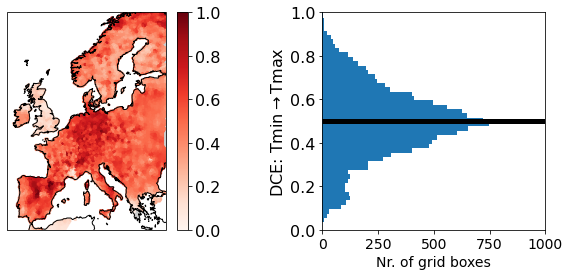

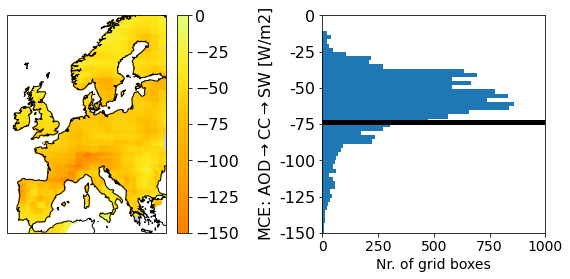

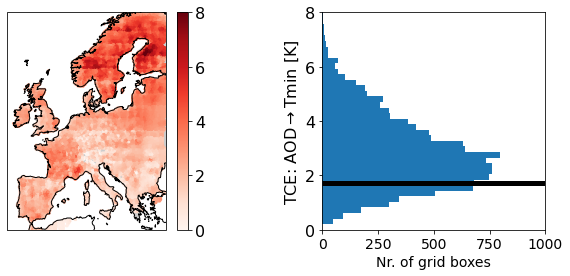

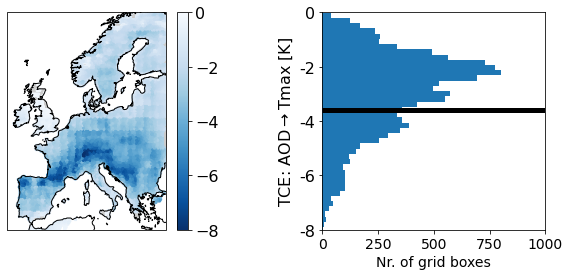

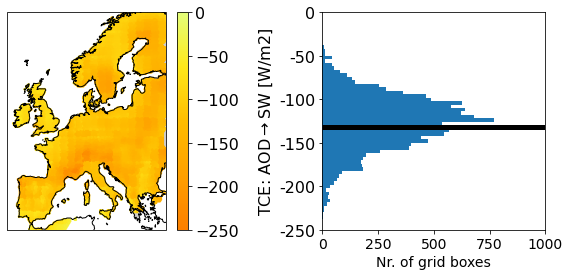

In [6]:
## Causel effect heat maps and European disyribution of causal effects - Figure A6

crs={'init':'epsg:4326'}

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
eu = world[world['continent'] == "Europe"]

geo_df=geopandas.GeoDataFrame(station_locDF,crs=crs,geometry=geopandas.points_from_xy(station_locDF['lon'], station_locDF['lat']))

c1 = ['DCE: AOD','DCE: AOD','DCE: AOD','DCE: CC','DCE: CC','DCE: CC','DCE: SW','DCE: Tmax','DCE: Tmin','MCE: AOD','TCE: AOD','TCE: AOD','TCE: AOD']
c2 = ['CC','SW','Tmin','SW','Tmax','Tmin','Tmax','Tmin','Tmax','CC','Tmin','Tmax','SW']
c3 = ['','','','','','','','','','SW','','','']
    
lab = ['','[W/m2]','[K]','[W/m2]','[K]','[K]','[K/W/m2]','','','[W/m2]','[K]','[K]','[W/m2]']

vmax = [1.2,0,6,0,10,8,0.06,0.6,1,0,8,0,0]
vmin = [0,-160,0,-250,-10,-8,0,0,0,-150,0,-8,-250]
cmap = ['bone','Wistia_r','Reds','Wistia_r','RdBu_r','RdBu_r','Reds','Reds','Reds','Wistia_r','Reds','Blues_r','Wistia_r']

cmin = [0, -160, 0, -250, -10, -8, 0, 0, 0, -150, 0, -8, -250]
cmax = [1.2, 0, 6, 0, 10, 8, 0.06, 0.6, 1, 0, 8, 0, 0]
n = [0.2, 50, 1, 50, 2, 2, 0.02, 0.1, 0.2, 25, 2, 2, 50]

results = np.load('/data/ce-stations-01-14.npy')

for i in range(13):
    
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())
    eu.plot(ax=ax1,alpha=0.4,color="grey")
    img = geo_df.plot(column = cols[i],ax=ax1,markersize=3, cmap = cmap[i], vmin = vmin[i], vmax = vmax[i], legend = True)#,legend_kwds = {'label':'Causal Effect ' + lab[i]})
    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=16)
    img._A = []
    ax1.set_xlim(-12,30)
    ax1.set_ylim(35,70)
    ax1.coastlines()
    # ax1.set_title(cols[i], fontsize = 18)
    
    ax2 = fig.add_subplot(1,2,2)
    fig.add_axes(ax2)
    ax2.hist(geo_df[cols[i]], bins = 50, orientation = 'horizontal')
    ax2.set_xlim(0,1000)
    ax2.set_ylim(cmin[i],cmax[i])
    if i == 9:
            ax2.set_ylabel(c1[i] + r'$\rightarrow$' + c2[i] + r'$\rightarrow$' + c3[i] + ' ' +lab[i], fontsize = 16)
    else:
        ax2.set_ylabel(c1[i] + r'$\rightarrow$' + c2[i] + ' ' +lab[i], fontsize = 16)
    ax2.set_yticks(np.arange(cmin[i],cmax[i]+n[i],n[i]))
    if i in [0,7,8]:
        ax2.set_yticklabels(np.round(np.arange(cmin[i],cmax[i]+n[i],n[i]),2), fontsize = 16)
    else:
        ax2.set_yticklabels(np.arange(cmin[i],cmax[i]+n[i],n[i]), fontsize = 16)
    ax2.set_xticks([0, 250, 500, 750, 1000])
    ax2.set_xticklabels([0, 250, 500, 750, 1000], fontsize = 14)
    ax2.hlines(results[i,0],0,1000, color = 'black', linewidth = 5)
    ax2.set_xlabel('Nr. of grid boxes', fontsize = 14)
    plt.subplots_adjust(wspace = 0.5)

    plt.savefig('...', dpi = 600)